In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker

In [2]:
import tools

In [3]:
data = pd.read_json("data/flink/commits_20220602-16h05m47s_apache_flink_master_commits.txt", lines=True)
tools.initialize_datetime(data)
data = data.sort_values(by='authoredDate')
data['_count'] = 1

 ## Contributor Committer relationship

In [4]:
committer_contributor_relationship = data[['committerName', 'authorName', '_count']].dropna().drop_duplicates()
committer_contributor_unique_count = committer_contributor_relationship.groupby(['committerName'])['_count'].sum()

In [5]:
print(f'Average number of committer to contributor connections {committer_contributor_unique_count.mean()}')

Average number of committer to contributor connections 22.13953488372093


In [6]:
committer_contributor_unique_count_sorted = committer_contributor_unique_count.sort_values(ascending=False)
committer_contributor_unique_count_sorted[committer_contributor_unique_count_sorted > 10]
committer_contributor_value_counts = committer_contributor_unique_count.value_counts().sort_index()


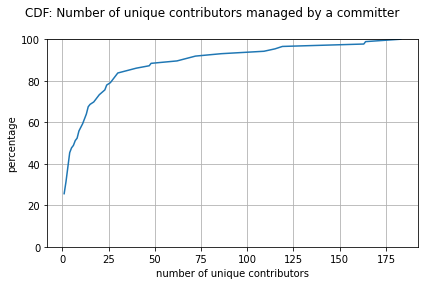

In [7]:
f, ax = plt.subplots()
ser = committer_contributor_value_counts.cumsum() / committer_contributor_value_counts.sum() * 100
ser.plot(ax=ax)
ax.grid()
ax.set(xlabel='number of unique contributors', ylabel='percentage', ylim=(0, 100))
f.suptitle('CDF: Number of unique contributors managed by a committer')
tools.savefig(f, "commits_cdf_ratio_contributors_to_committers")

80 % of all committers manage the contributions of small circle of contributors (<=25).

Almost 10% manage contributions of at least 75 contributors.

In [8]:
def avg_committer_contributor_relationship(fragment: pd.DataFrame):
    fragment = fragment[['committerName', 'authorName', '_count']].dropna().drop_duplicates()
    return fragment.groupby(['committerName'])['_count'].sum().mean()

def std_committer_contributor_relationship(fragment: pd.DataFrame):
    fragment = fragment[['committerName', 'authorName', '_count']].dropna().drop_duplicates()
    return fragment.groupby(['committerName'])['_count'].sum().std()

avg_committer_contributor_per_year = data.set_index('authoredDate').groupby(pd.Grouper(freq='Y')).apply(avg_committer_contributor_relationship)
std_committer_contributor_per_year = data.set_index('authoredDate').groupby(pd.Grouper(freq='Y')).apply(std_committer_contributor_relationship)

In [9]:
active_committers = data.set_index('authoredDate').groupby(pd.Grouper(freq='Y'))['committerDatabaseId'].nunique()
active_contributors = data.set_index('authoredDate').groupby(pd.Grouper(freq='Y'))['authorDatabaseId'].nunique()

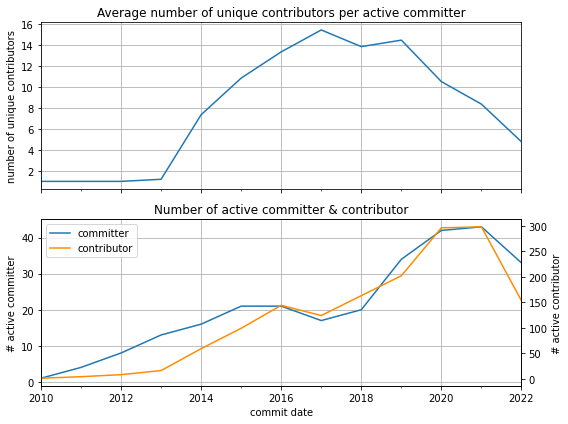

In [10]:
f, axes = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))

def plot(ax):
    avg_committer_contributor_per_year.plot(ax=ax)
    #ax2 = ax.twinx()
    #std_committer_contributor_per_year.plot(ax=ax2)
    ax.grid()
    ax.set(xlabel='commit date', ylabel='number of unique contributors')
    ax.set_title('Average number of unique contributors per active committer')

def plot2(ax):
    active_committers.plot(ax=ax, label='committer')
    ax2 = ax.twinx()
    active_contributors.plot(ax=ax2, label='contributor', color='darkorange')
    ax.set(xlabel='commit date', ylabel='# active committer')
    ax2.set(ylabel='# active contributor')
    ax.set_title('Number of active committer & contributor')
    ax.grid()
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc=0)


plot(axes[0])
plot2(axes[1])

f.tight_layout()
tools.savefig(f, 'commits_committer_active_contributor')